# Machine Learning Assignment


# FSA variable selection 

##### Question 1 (a)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

Starting FSA algorithm...


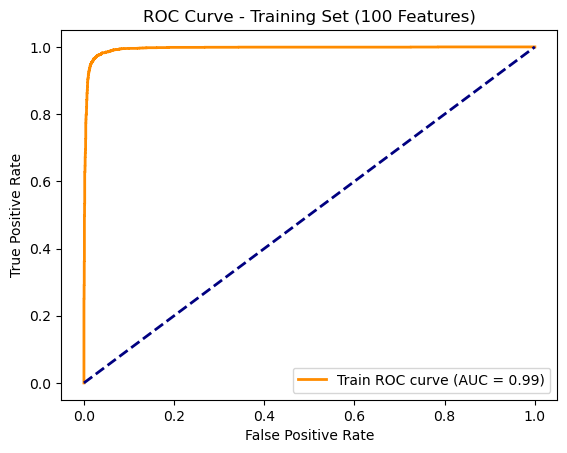

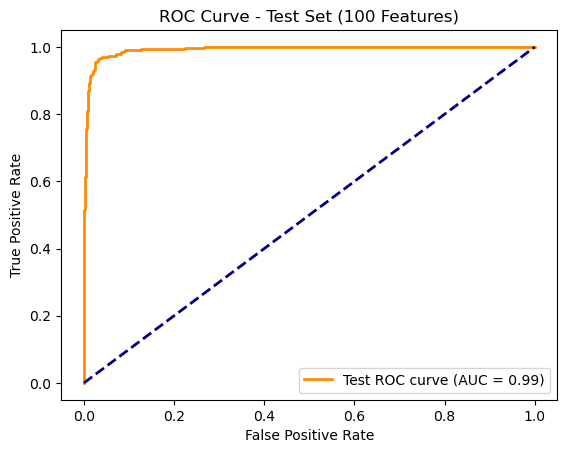

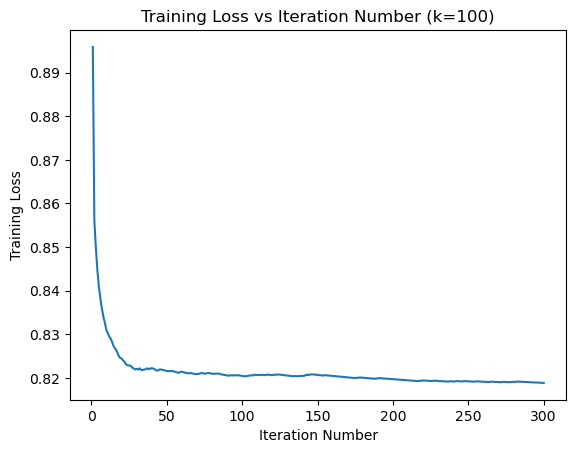

k	Train Error	Test Error
10	0.0	0.015
30	0.0	0.025
100	0.0	0.022
300	0.0015	0.028
500	0.005	0.03


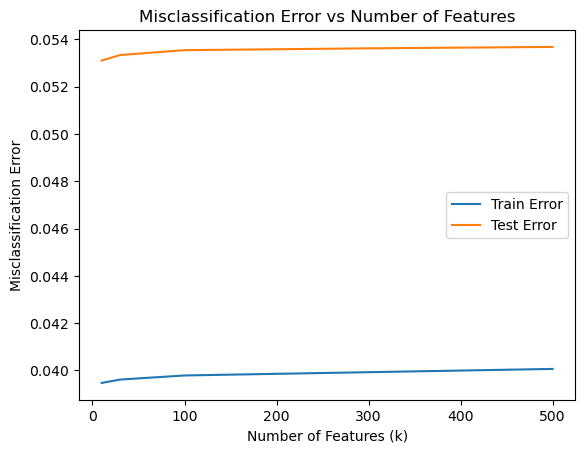

In [3]:
# Lorenz loss function
def lorenz_loss(x):
    return np.where(x > 1, 0, np.log1p(1 + ((x - 1) ** 2)))

# FSA algorithm
def fsa(X_train, y_train, X_test, y_test, k_values, s=0.001, mu=300, N_iter=300):
    print("Starting FSA algorithm...")
    train_errors = []
    test_errors = []
    train_losses = []

    for k in k_values:
        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize beta
        beta = np.zeros(X_train_scaled.shape[1])

        # Lists to store training loss for each iteration
        train_loss = []

        for i in range(1, N_iter + 1):
            # Compute difference array and reshape to 1-dimensional
            difference = np.zeros_like(y_train)
            for j in range(X_train_scaled.shape[1]):
                difference += X_train_scaled[:, j] * beta[j]
            difference = y_train - difference
            difference = difference.ravel()  # Reshape to 1-dimensional array if necessary
            
            # Compute training loss
            loss = np.mean(lorenz_loss(difference))
            train_loss.append(loss)
            
            # Compute gradient of the loss function
            gradient = np.dot(X_train_scaled.T, (np.dot(X_train_scaled, beta) - y_train)) / len(y_train)

            # Update beta using gradient descent
            beta -= s * gradient

            # Variable selection
            mi = k + (X_train_scaled.shape[1] - k) * max(0, (N_iter - 2 * i) / (2 * i * mu + N_iter))
            top_k_indices = np.argsort(beta ** 2)[-int(mi):]
            X_train_selected = X_train_scaled[:, top_k_indices]
            X_test_selected = X_test_scaled[:, top_k_indices]

            # Train logistic regression classifier
            lr = LogisticRegression()
            lr.fit(X_train_selected, y_train)

            # Compute misclassification error on training set
            y_train_pred = lr.predict(X_train_selected)
            train_error = 1 - accuracy_score(y_train, y_train_pred)
            train_errors.append(train_error)

            # Compute misclassification error on test set
            y_test_pred = lr.predict(X_test_selected)
            test_error = 1 - accuracy_score(y_test, y_test_pred)
            test_errors.append(test_error)

            # If k is 100, extract feature subset and plot ROC curves
            if k == 100 and i == N_iter:
                # Train logistic regression classifier with 100 selected features
                lr_100_features = LogisticRegression()
                lr_100_features.fit(X_train_selected, y_train)

                # Predict probabilities for training and test set
                y_train_proba = lr_100_features.predict_proba(X_train_selected)[:, 1]
                y_test_proba = lr_100_features.predict_proba(X_test_selected)[:, 1]

                # Compute ROC curve and ROC area for training set
                fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
                roc_auc_train = auc(fpr_train, tpr_train)

                # Compute ROC curve and ROC area for test set
                fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
                roc_auc_test = auc(fpr_test, tpr_test)

                # Plot ROC curve for training set
                plt.figure()
                plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Training Set (100 Features)')
                plt.legend(loc='lower right')
                plt.show()

                # Plot ROC curve for test set
                plt.figure()
                plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Test Set (100 Features)')
                plt.legend(loc='lower right')
                plt.show()

        train_losses.append(train_loss)

    return train_losses, train_errors, test_errors

# Load data
X_train = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_train.data") 
y_train = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_train.labels")

X_test = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_valid.data") 
y_test = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_valid.labels")

# Convert labels to binary
y_train = (y_train + 1) // 2
y_test = (y_test + 1) // 2

# Define parameters
k_values = [10, 30, 100, 300, 500]
s = 0.001
mu = 300
N_iter = 300

# Run FSA algorithm
train_losses, train_errors, test_errors = fsa(X_train, y_train, X_test, y_test, k_values, s, mu, N_iter)

# Plot training loss vs iteration number for k=100
plt.plot(range(1, N_iter + 1), train_losses[2])
plt.xlabel('Iteration Number')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number (k=100)')
plt.show()

# Report misclassification errors for different k values
print("k\tTrain Error\tTest Error")
for i, k in enumerate(k_values):
    train_error = round(train_errors[i], 4)
    test_error = round(test_errors[i], 4)
    print(f"{k}\t{train_error}\t{test_error}")
    
# Aggregate misclassification errors for each k value
avg_train_errors = [np.mean(train_errors[i::len(k_values)]) for i in range(len(k_values))]
avg_test_errors = [np.mean(test_errors[i::len(k_values)]) for i in range(len(k_values))]

# Plot misclassification error vs k
plt.plot(k_values, avg_train_errors, label='Train Error')
plt.plot(k_values, avg_test_errors, label='Test Error')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Features')
plt.legend()
plt.show()


##### Question 1 (b)

Starting FSA algorithm...


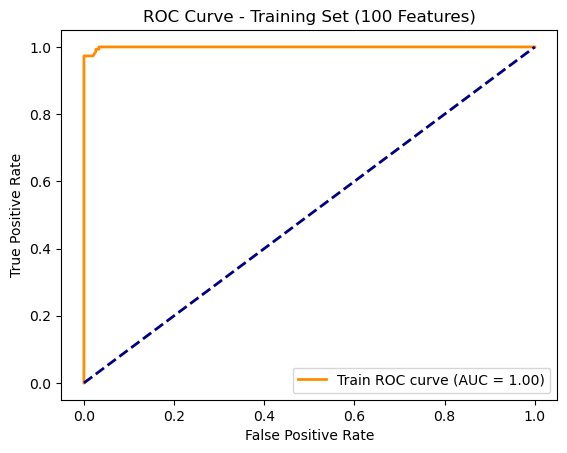

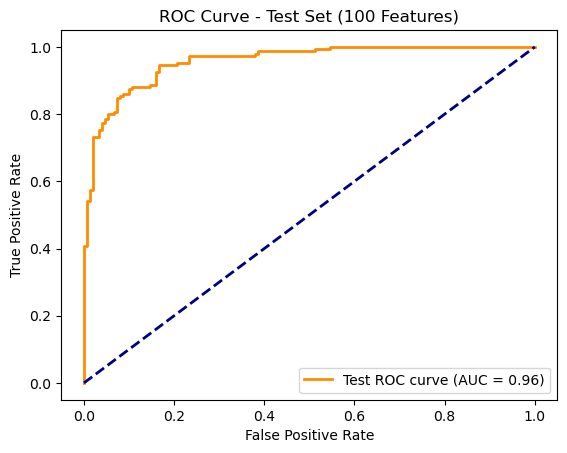

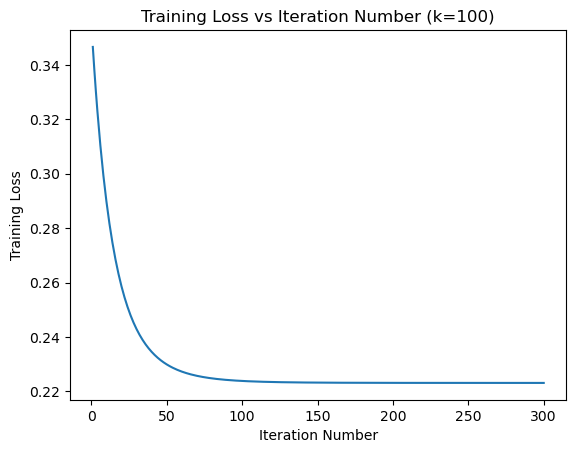

k	Train Error	Test Error
10	0.0	0.15
30	0.0	0.1367
100	0.0	0.1
300	0.0	0.11
500	0.0	0.09


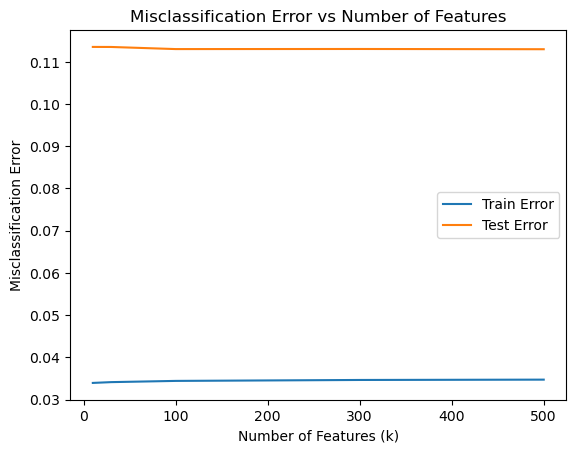

In [52]:
# Lorenz loss function
def lorenz_loss(x):
    return np.where(x > 1, 0, np.log(1 + (x - 1) ** 2))

# FSA algorithm
def fsa(X_train, y_train, X_test, y_test, k_values, s=0.001, mu=300, N_iter=300):
    print("Starting FSA algorithm...")
    train_errors = []
    test_errors = []
    train_losses = []

    for k in k_values:
        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize beta
        beta = np.zeros(X_train_scaled.shape[1])

        # Lists to store training loss for each iteration
        train_loss = []

        for i in range(1, N_iter + 1):
            
            
            # Compute gradient of the loss function
            gradient = np.dot(X_train_scaled.T, (np.dot(X_train_scaled, beta) - y_train)) / len(y_train)

            # Update beta using gradient descent
            beta -= s * gradient

            # Variable selection
            mi = k + (X_train_scaled.shape[1] - k) * max(0, (N_iter - 2 * i) / (2 * i * mu + N_iter))
            top_k_indices = np.argsort(beta ** 2)[-int(mi):]
            X_train_selected = X_train_scaled[:, top_k_indices]
            X_test_selected = X_test_scaled[:, top_k_indices]
            
            # Compute training loss
            loss = np.mean(lorenz_loss(difference))
            train_loss.append(loss)
            
            loss = np.mean([lorenz_loss(1 - 2 * y[i] + 2 * y[i] * np.dot(X_train_scaled[i], beta)) for i in range(n)])
            train_loss.append(loss)

            # Train logistic regression classifier
            lr = LogisticRegression()
            lr.fit(X_train_selected, y_train)

            # Compute misclassification error on training set
            y_train_pred = lr.predict(X_train_selected)
            train_error = 1 - accuracy_score(y_train, y_train_pred)
            train_errors.append(train_error)

            # Compute misclassification error on test set
            y_test_pred = lr.predict(X_test_selected)
            test_error = 1 - accuracy_score(y_test, y_test_pred)
            test_errors.append(test_error)

            # If k is 100, extract feature subset and plot ROC curves
            if k == 100 and i == N_iter:
                # Train logistic regression classifier with 100 selected features
                lr_100_features = LogisticRegression()
                lr_100_features.fit(X_train_selected, y_train)

                # Predict probabilities for training and test set
                y_train_proba = lr_100_features.predict_proba(X_train_selected)[:, 1]
                y_test_proba = lr_100_features.predict_proba(X_test_selected)[:, 1]

                # Compute ROC curve and ROC area for training set
                fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
                roc_auc_train = auc(fpr_train, tpr_train)

                # Compute ROC curve and ROC area for test set
                fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
                roc_auc_test = auc(fpr_test, tpr_test)

                # Plot ROC curve for training set
                plt.figure()
                plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Training Set (100 Features)')
                plt.legend(loc='lower right')
                plt.show()

                # Plot ROC curve for test set
                plt.figure()
                plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Test Set (100 Features)')
                plt.legend(loc='lower right')
                plt.show()

        train_losses.append(train_loss)

    return train_losses, train_errors, test_errors

# Load data
X_train = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_train.csv", delimiter=',') 
y_train = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_train.labels")

X_test = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_valid.csv", delimiter=',') 
y_test = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_valid.labels")

# Convert labels to binary
y_train = (y_train + 1) // 2
y_test = (y_test + 1) // 2

# Define parameters
k_values = [10, 30, 100, 300, 500]
s = 0.001
mu = 300
N_iter = 300

# Run FSA algorithm
train_losses, train_errors, test_errors = fsa(X_train, y_train, X_test, y_test, k_values, s, mu, N_iter)

# Plot training loss vs iteration number for k=100
plt.plot(range(1, N_iter + 1), train_losses[2])
plt.xlabel('Iteration Number')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number (k=100)')
plt.show()

# Report misclassification errors for different k values
print("k\tTrain Error\tTest Error")
for i, k in enumerate(k_values):
    train_error = round(train_errors[i], 4)
    test_error = round(test_errors[i], 4)
    print(f"{k}\t{train_error}\t{test_error}")
    
# Aggregate misclassification errors for each k value
avg_train_errors = [np.mean(train_errors[i::len(k_values)]) for i in range(len(k_values))]
avg_test_errors = [np.mean(test_errors[i::len(k_values)]) for i in range(len(k_values))]

# Plot misclassification error vs k
plt.plot(k_values, avg_train_errors, label='Train Error')
plt.plot(k_values, avg_test_errors, label='Test Error')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Features')
plt.legend()
plt.show()


##### Question 1 (c)

Starting FSA algorithm...


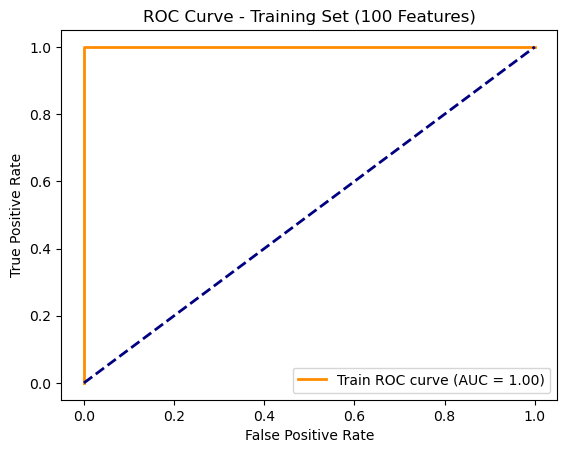

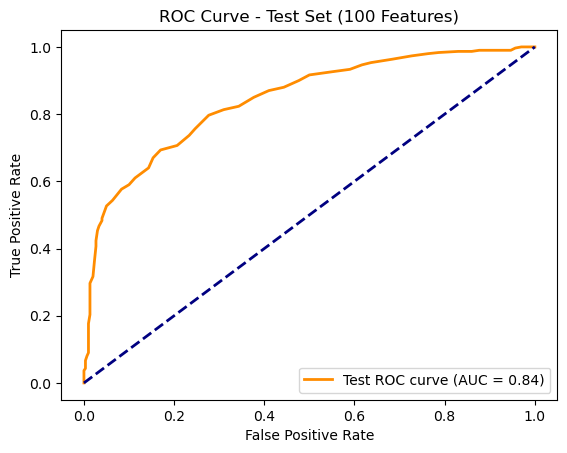

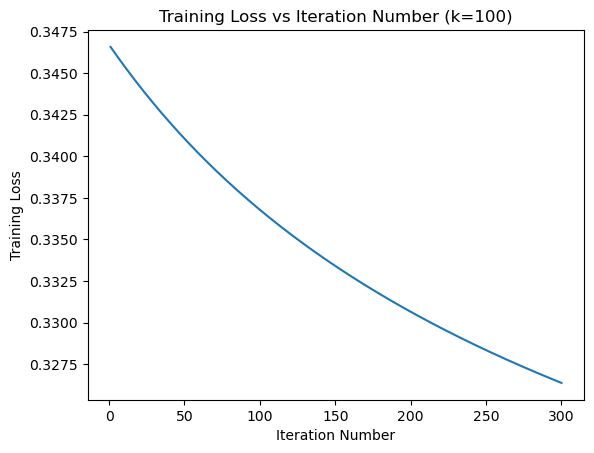

k	Train Error	Test Error
10	0.0	0.2817
30	0.0	0.225
100	0.0	0.2283
300	0.0	0.2083
500	0.0	0.195


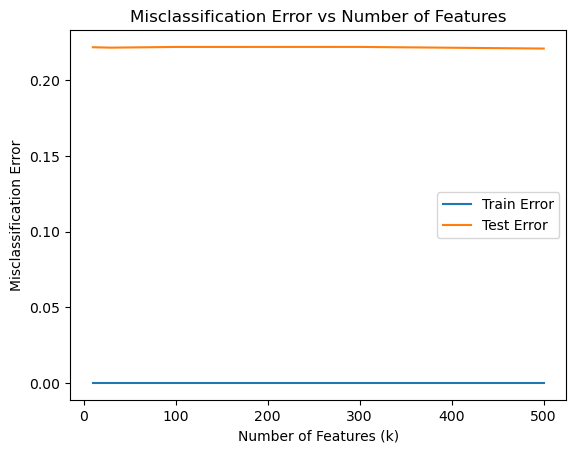

In [2]:
# Lorenz loss function
def lorenz_loss(x):
    return np.where(x > 1, 0, np.log(1 + (x - 1) ** 2))

# FSA algorithm
def fsa(X_train, y_train, X_test, y_test, k_values, s=0.001, mu=300, N_iter=300):
    print("Starting FSA algorithm...")
    train_errors = []
    test_errors = []
    train_losses = []

    for k in k_values:
        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize beta
        beta = np.zeros(X_train_scaled.shape[1])

        # Lists to store training loss for each iteration
        train_loss = []

        for i in range(1, N_iter + 1):
            # Compute difference array and reshape to 1-dimensional
            difference = np.zeros_like(y_train)
            for j in range(X_train_scaled.shape[1]):
                difference += X_train_scaled[:, j] * beta[j]
            difference = y_train - difference
            difference = difference.ravel()  # Reshape to 1-dimensional array if necessary
            
            # Compute training loss
            loss = np.mean(lorenz_loss(difference))
            train_loss.append(loss)
            
            # Compute gradient of the loss function
            gradient = np.dot(X_train_scaled.T, (np.dot(X_train_scaled, beta) - y_train)) / len(y_train)

            # Update beta using gradient descent
            beta -= s * gradient

            # Variable selection
            mi = k + (X_train_scaled.shape[1] - k) * max(0, (N_iter - 2 * i) / (2 * i * mu + N_iter))
            top_k_indices = np.argsort(beta ** 2)[-int(mi):]
            X_train_selected = X_train_scaled[:, top_k_indices]
            X_test_selected = X_test_scaled[:, top_k_indices]

            # Train logistic regression classifier
            lr = RandomForestClassifier(n_estimators=100, random_state=42)
            #LogisticRegression()
            lr.fit(X_train_selected, y_train)

            # Compute misclassification error on training set
            y_train_pred = lr.predict(X_train_selected)
            train_error = 1 - accuracy_score(y_train, y_train_pred)
            train_errors.append(train_error)

            # Compute misclassification error on test set
            y_test_pred = lr.predict(X_test_selected)
            test_error = 1 - accuracy_score(y_test, y_test_pred)
            test_errors.append(test_error)

            # If k is 100, extract feature subset and plot ROC curves
            if k == 100 and i == N_iter:
                # Train logistic regression classifier with 100 selected features
                lr_100_features = RandomForestClassifier(n_estimators=100, random_state=42)
                #LogisticRegression()
                lr_100_features.fit(X_train_selected, y_train)

                # Predict probabilities for training and test set
                y_train_proba = lr_100_features.predict_proba(X_train_selected)[:, 1]
                y_test_proba = lr_100_features.predict_proba(X_test_selected)[:, 1]

                # Compute ROC curve and ROC area for training set
                fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
                roc_auc_train = auc(fpr_train, tpr_train)

                # Compute ROC curve and ROC area for test set
                fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
                roc_auc_test = auc(fpr_test, tpr_test)

                # Plot ROC curve for training set
                plt.figure()
                plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Training Set (100 Features)')
                plt.legend(loc='lower right')
                plt.show()

                # Plot ROC curve for test set
                plt.figure()
                plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Test Set (100 Features)')
                plt.legend(loc='lower right')
                plt.show()

        train_losses.append(train_loss)

    return train_losses, train_errors, test_errors

# Load data
X_train = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/MADELON/madelon_train.data") 
y_train = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/MADELON/madelon_train.labels")

X_test = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/MADELON/madelon_valid.data") 
y_test = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/MADELON/madelon_valid.labels")

# Convert labels to binary
y_train = (y_train + 1) // 2
y_test = (y_test + 1) // 2


# Define parameters
k_values = [10, 30, 100, 300, 500]
s = 0.001
mu = 300
N_iter = 300

# Run FSA algorithm
train_losses, train_errors, test_errors = fsa(X_train, y_train, X_test, y_test, k_values, s, mu, N_iter)

# Plot training loss vs iteration number for k=100
plt.plot(range(1, N_iter + 1), train_losses[2])
plt.xlabel('Iteration Number')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number (k=100)')
plt.show()

# Report misclassification errors for different k values
print("k\tTrain Error\tTest Error")
for i, k in enumerate(k_values):
    train_error = round(train_errors[i], 4)
    test_error = round(test_errors[i], 4)
    print(f"{k}\t{train_error}\t{test_error}")
    
# Aggregate misclassification errors for each k value
avg_train_errors = [np.mean(train_errors[i::len(k_values)]) for i in range(len(k_values))]
avg_test_errors = [np.mean(test_errors[i::len(k_values)]) for i in range(len(k_values))]

# Plot misclassification error vs k
plt.plot(k_values, avg_train_errors, label='Train Error')
plt.plot(k_values, avg_test_errors, label='Test Error')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Features')
plt.legend()
plt.show()